max Re(lambda(A)) = -4.489702961021306e-19


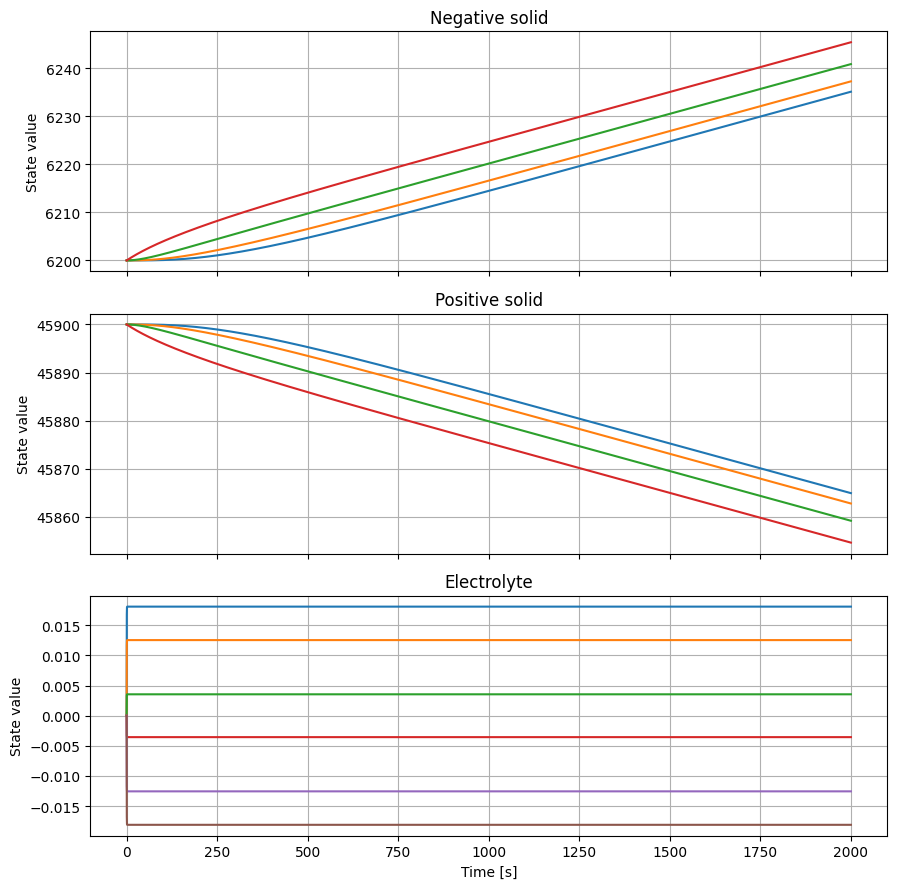

=== State Extrema Summary ===
cn      : min= 6.200e+03, max= 6.245e+03
cp      : min= 4.585e+04, max= 4.590e+04
ce      : min=-1.811e-02, max= 1.811e-02
Eq.40 consistency, max |residual| = 0.0


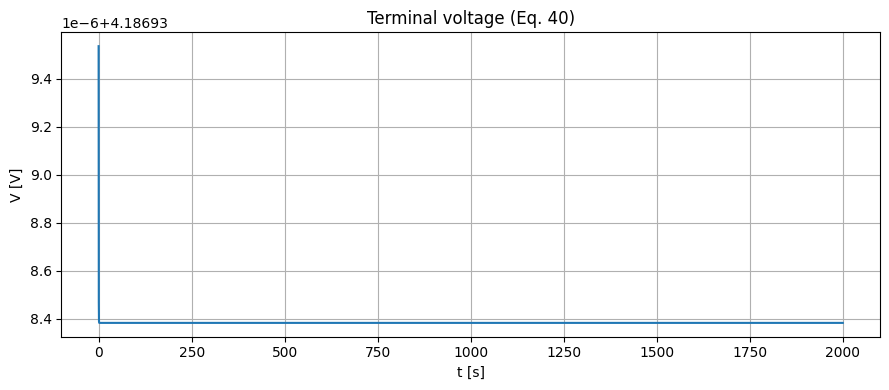

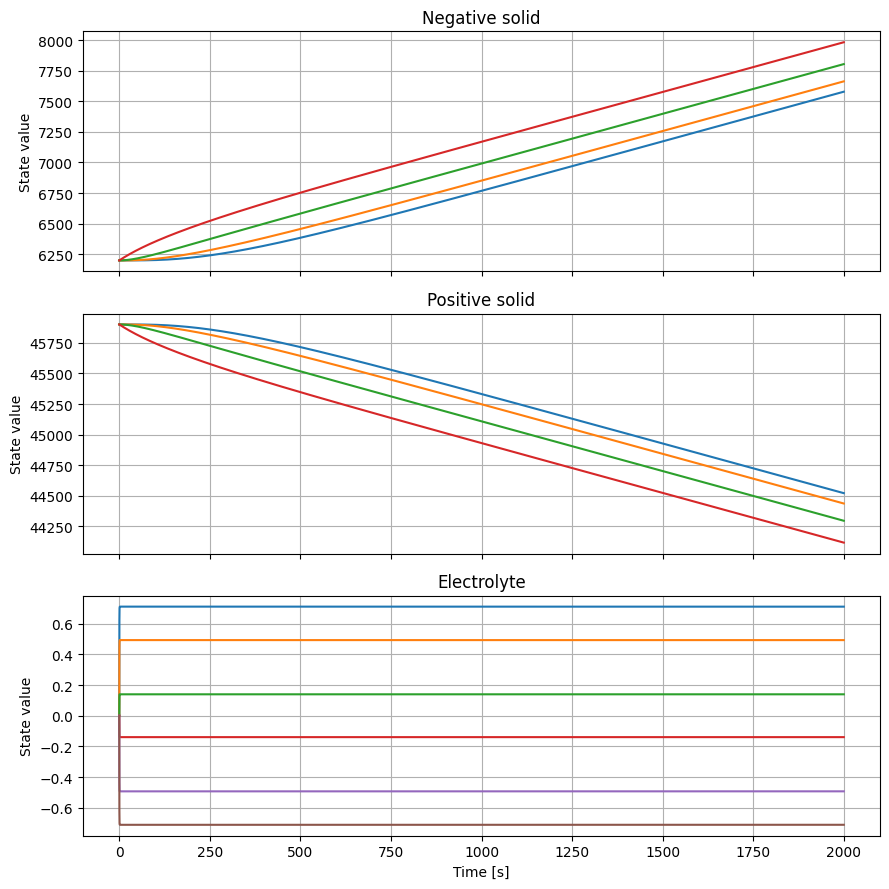

=== State Extrema Summary ===
cn      : min= 6.200e+03, max= 7.982e+03
cp      : min= 4.412e+04, max= 4.590e+04
ce      : min=-7.116e-01, max= 7.116e-01


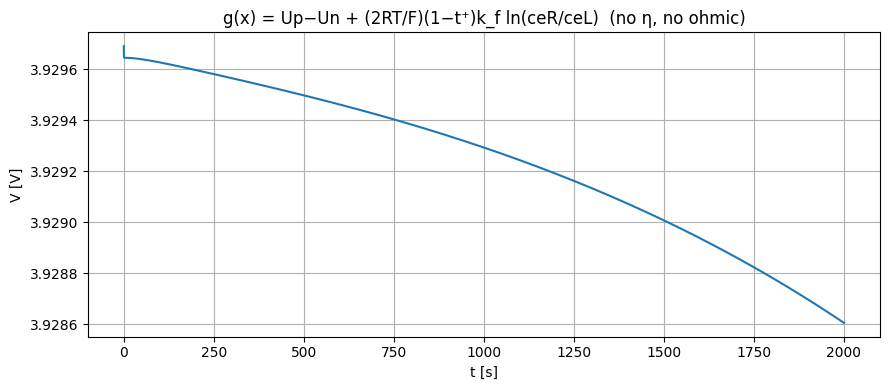

In [5]:
from __future__ import annotations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass
import control as ct
from scipy.linalg import block_diag
from IPython.display import display

# --------------------------
# Index map (global)
# --------------------------
# x = [c_n1,c_n2,c_n3,c_n4,  c_p1,c_p2,c_p3,c_p4,  ce1,ce2,ce3,ce4,ce5,ce6]
IDX = {
    "cn": slice(0,4),
    "cp": slice(4,8),
    "ce": slice(8,14),

    # "Surface" choices used by the voltage layer (you can change these later)
    "cn_surf": 2,    # cn3 as neg "surface"
    "cp_surf": 4,    # absolute index 4 (= local cp1) as pos "surface"
    "ce_left": 8,    # ce1  (negative-collector end)
    "ce_right": 13,  # ce6  (positive-collector end)
}

# --------------------------
# Physical constants
# --------------------------
@dataclass
class PhysParams:
    R: float = 8.314462618    # J/(mol·K)
    F: float = 96485.33212    # C/mol
    T: float = 298.15         # K
    t_plus: float = 0.38
    kf: float = 1.0           # multiplier on the ln term
    Re: float = 0.0           # series ohmic, if used
    Rf: float = 0.0           # film (aging), if used
    csn_max: float = 3.1e4    # [mol/m^3]
    csp_max: float = 5.1e4    # [mol/m^3]

PP = PhysParams()
R_GAS = PP.R

# --------------------------
# Solid diffusion (4×4)
# --------------------------
def build_An(Dn: float, Rn: float) -> np.ndarray:
    s = Dn/(Rn**2)
    A = np.zeros((4,4))
    A[0,0], A[0,1] = -24*s,  24*s
    A[1,0], A[1,1], A[1,2] =  16*s, -40*s, 24*s
    A[2,1], A[2,2], A[2,3] =  16*s, -40*s, 24*s
    A[3,2], A[3,3] =  16*s, -16*s
    return A

def build_Ap(Dp: float, Rp: float) -> np.ndarray:
    s = Dp/(Rp**2)
    A = np.zeros((4,4))
    A[0,0], A[0,1] = -24*s,  24*s
    A[1,0], A[1,1], A[1,2] =  16*s, -40*s, 24*s
    A[2,1], A[2,2], A[2,3] =  16*s, -40*s, 24*s
    A[3,2], A[3,3] =  16*s, -16*s
    return A

def build_Bn(Dn: float, Rn: float, a: float, A: float, L_n: float) -> np.ndarray:
    # Source acts at the "surface" CV (last node in our 4-CV stencil)
    # Note: the exact coefficient depends on your stencil; keeping a clean symbolic form.
    b = np.zeros((4,1))
    b[-1,0] = +(6.0/Rn) * (1.0/(PP.F * a * A * L_n))
    return b

def build_Bp(Dp: float, Rp: float, a: float, A: float, L_p: float) -> np.ndarray:
    b = np.zeros((4,1))
    b[-1,0] = -(6.0/Rp) * (1.0/(PP.F * a * A * L_p))
    return b

# --------------------------
# Electrolyte diffusion (6×6)
#   IMPORTANT: dissipative sign (negative diagonal)
# --------------------------
def build_Ae(D_e: float, eps: float, Ln: float, Lsep: float, Lp: float) -> np.ndarray:
    K = D_e/eps
    Ae = np.zeros((6,6))
    w_in   = lambda L:  K * 4.0 / (L**2)
    w_intf = lambda La, Lb: K * 16.0 / ((La + Lb)**2)
    w11 = w_in(Ln);   w12 = w_intf(Ln, Lsep)
    w23 = w_in(Lsep); w34 = w_intf(Lsep, Lp)
    w45 = w_in(Lp)

    # ce1
    Ae[0,0] = -(w11);      Ae[0,1] = +(w11)
    # ce2
    Ae[1,0] = +(w11);      Ae[1,1] = -(w11 + w12);  Ae[1,2] = +(w12)
    # ce3
    Ae[2,1] = +(w12);      Ae[2,2] = -(w12 + w23);  Ae[2,3] = +(w23)
    # ce4
    Ae[3,2] = +(w23);      Ae[3,3] = -(w23 + w34);  Ae[3,4] = +(w34)
    # ce5
    Ae[4,3] = +(w34);      Ae[4,4] = -(w34 + w45);  Ae[4,5] = +(w45)
    # ce6
    Ae[5,4] = +(w45);      Ae[5,5] = -(w45)
    return Ae

def build_Be(Ln: float, Lp: float, eps1: float, eps3: float,
             A: float, t_plus: float, sign_right: float = -1.0) -> np.ndarray:
    """
    Distributed source/sink in electrode regions only (separator = 0):
      neg: +(1-t+)/ (F A Ln eps1)
      pos: sign_right*(1-t+)/ (F A Lp eps3)   (default = sink)
    """
    b = np.zeros((6,1))
    s1 = +(1.0 - t_plus) / (PP.F * A * Ln * eps1)
    s3 =  sign_right     * (1.0 - t_plus) / (PP.F * A * Lp * eps3)
    b[0,0] = s1; b[1,0] = s1
    b[4,0] = s3; b[5,0] = s3
    return b

# --------------------------
# System assembly
# --------------------------
def assemble_system(params: dict):
    # geometry & transport
    Dn = params.get("Dn", 1e-14); Rn = params.get("Rn", 5e-6)
    Dp = params.get("Dp", 1e-14); Rp = params.get("Rp", 5e-6)
    L1 = params.get("L1", 25e-6); L2 = params.get("L2", 20e-6); L3 = params.get("L3", 25e-6)
    a_s_n = params.get("a_s_n", 1.0e6); a_s_p = params.get("a_s_p", 1.0e6)

    # areas
    electrode_area = params.get("A", params.get("A_e", 1.0))

    # electrolyte
    D_e = params.get("D_e", params.get("De", 7.23e-10))
    eps = params.get("eps", 0.30)

    # blocks
    An = build_An(Dn, Rn);  Ap = build_Ap(Dp, Rp)
    Bn = build_Bn(Dn, Rn, a_s_n, electrode_area, L1)
    Bp = build_Bp(Dp, Rp, a_s_p, electrode_area, L3)
    Ae = build_Ae(D_e, eps, L1, L2, L3)
    Be = build_Be(L1, L3, eps, eps, electrode_area, PP.t_plus)

    # global
    Aglob = block_diag(An, Ap, Ae)
    Bglob = np.vstack([Bn, Bp, Be])

    state_names = [f'cn{i}' for i in range(1,5)] + \
                  [f'cp{i}' for i in range(1,5)] + \
                  [f'ce{i}' for i in range(1,7)]

    # Linear system (C = I for convenience)
    S = ct.ss(Aglob, Bglob, np.eye(Aglob.shape[0]), np.zeros((Aglob.shape[0],1)))
    return S, Aglob, Bglob, (An, Ap, Ae, Bn, Bp, Be), state_names

# --------------------------
# Helpers: ICs, display, plots
# --------------------------
def make_x0(theta_n0=0.2, theta_p0=0.9, ce0=0.0,  # ce0=0.0 if you treat ce states as deviations
            pp: PhysParams = PP):
    x0 = np.zeros(14)
    x0[IDX["cn"]] = theta_n0 * pp.csn_max
    x0[IDX["cp"]] = theta_p0 * pp.csp_max
    x0[IDX["ce"]] = ce0
    return x0

def show_matrices(An, Ap, Ae, Bn, Bp, Be, A, B, state_names):
    def df(M, rnames, cnames): return pd.DataFrame(M, index=rnames, columns=cnames)
    cn_names = [f'cn{i}' for i in range(1, An.shape[0]+1)]
    cp_names = [f'cp{i}' for i in range(1, Ap.shape[0]+1)]
    ce_names = [f'ce{i}' for i in range(1, Ae.shape[0]+1)]
    display(df(An, cn_names, cn_names)); display(df(Bn, cn_names, ['u']))
    display(df(Ap, cp_names, cp_names)); display(df(Bp, cp_names, ['u']))
    display(df(Ae, ce_names, ce_names)); display(df(Be, ce_names, ['u']))
    display(df(A, state_names, state_names)); display(df(B, state_names, ['u']))
    print("A shape:", A.shape, "  B shape:", B.shape)

def plot_states_grouped(t: np.ndarray, X_TN: np.ndarray):
    fig, axs = plt.subplots(3, 1, figsize=(9, 9), sharex=True)
    axs[0].plot(t, X_TN[:, IDX["cn"]]); axs[0].set_title("Negative solid"); axs[0].grid(True)
    axs[1].plot(t, X_TN[:, IDX["cp"]]); axs[1].set_title("Positive solid"); axs[1].grid(True)
    axs[2].plot(t, X_TN[:, IDX["ce"]]); axs[2].set_title("Electrolyte");     axs[2].grid(True)
    for ax in axs: ax.set_ylabel("State value")
    axs[-1].set_xlabel("Time [s]")
    plt.tight_layout(); plt.show()

def report_extrema_matrix(X_TN: np.ndarray):
    print("=== State Extrema Summary ===")
    for name in ["cn","cp","ce"]:
        arr = X_TN[:, IDX[name]]
        print(f"{name:<8s}: min={arr.min(): .3e}, max={arr.max(): .3e}")

# --------------------------
# Voltage layer
# --------------------------
def ocp_p_safe(xp: np.ndarray) -> np.ndarray:
    xp = np.clip(xp, 1e-6, 1-1e-6)
    return 4.15 - 0.12*np.tanh((xp - 0.60)/0.08)

def ocp_n_safe(xn: np.ndarray) -> np.ndarray:
    xn = np.clip(xn, 1e-6, 1-1e-6)
    return 0.10 + 0.80*(1/(1 + np.exp(-(xn-0.50)/0.04)))

def safe_log_ratio(a, b, eps=1e-12):
    a = np.maximum(a, eps); b = np.maximum(b, eps)
    return np.log(a/b)

@dataclass
class VParams:
    A: float = 1.0
    L_n: float = 25e-6
    L_p: float = 25e-6
    a_s_n: float = 1.0e6
    a_s_p: float = 1.0e6
    k_n: float = 2.0e-11
    k_p: float = 2.0e-11
    cs_n_max: float = 3.1e4
    cs_p_max: float = 5.1e4
    ce0: float = 1000.0
    t_plus: float = PP.t_plus
    k_f: float = 1.0
    Re: float = 0.0
    Rf: float = 0.0
    R_ohm: float = 0.0
    T: float = 298.15
    ce_is_deviation: bool = True

def _extract_surface_and_ce(X_TN: np.ndarray, vp: VParams):
    xp = np.clip(X_TN[:, IDX["cp_surf"]], 1e-9, 1-1e-9) / vp.cs_p_max
    xn = np.clip(X_TN[:, IDX["cn_surf"]], 1e-9, 1-1e-9) / vp.cs_n_max
    ceL_raw = X_TN[:, IDX["ce_left"]];  ceR_raw = X_TN[:, IDX["ce_right"]]
    ceL = (vp.ce0 + ceL_raw) if vp.ce_is_deviation else ceL_raw
    ceR = (vp.ce0 + ceR_raw) if vp.ce_is_deviation else ceR_raw
    ceL = np.clip(ceL, 1e-9, None);     ceR = np.clip(ceR, 1e-9, None)
    return xp, xn, ceL, ceR

def _bv_eta_terms(I: np.ndarray, xp: np.ndarray, xn: np.ndarray, ceL: np.ndarray, ceR: np.ndarray, vp: VParams):
    # Optional (not used in state-only g(x)); kept for completeness
    F = PP.F
    Sp = vp.a_s_p * vp.A * vp.L_p
    Sn = vp.a_s_n * vp.A * vp.L_n
    ce_kin = np.clip(0.5*(ceL + ceR), 0.2*vp.ce0, 5.0*vp.ce0)
    mp = I / (F * vp.k_p * Sp * vp.cs_p_max * np.sqrt(ce_kin) * np.sqrt(np.clip(xp*(1-xp),1e-9,None)))
    mn = I / (F * vp.k_n * Sn * vp.cs_n_max * np.sqrt(ce_kin) * np.sqrt(np.clip(xn*(1-xn),1e-9,None)))
    eta_p = (2.0*R_GAS*vp.T/F) * np.arcsinh(0.5*mp)
    eta_n = (2.0*R_GAS*vp.T/F) * np.arcsinh(0.5*mn)
    return eta_p, eta_n

def voltage_eq40(T: np.ndarray, X_TN: np.ndarray, I: np.ndarray, vp: VParams,
                 ocp_p=ocp_p_safe, ocp_n=ocp_n_safe, ln_orientation: str = "right_over_left"):
    """
    Eq. 40-style:
      V = Up − Un + ηp + ηn + (2RT/F)(1−t⁺) k_f ln(ceR/ceL) − (Re+Rf) I
    """
    I = np.asarray(I).reshape(-1)
    xp, xn, ceL, ceR = _extract_surface_and_ce(X_TN, vp)
    Up, Un = ocp_p(xp), ocp_n(xn)
    eta_p, eta_n = _bv_eta_terms(I, xp, xn, ceL, ceR, vp)
    eta_sum = eta_p + eta_n
    ln_arg = (ceR/ceL) if ln_orientation == "right_over_left" else (ceL/ceR)
    dphi_e = (2.0*R_GAS*vp.T/PP.F) * (1.0 - vp.t_plus) * vp.k_f * np.log(ln_arg)
    ohmic  = -(vp.Re + vp.Rf) * I
    V = (Up - Un) + eta_sum + dphi_e + ohmic
    return V, {"Udiff":Up-Un, "eta_sum":eta_sum, "dphi_e":dphi_e, "ohmic":ohmic, "V":V,
               "xp":xp, "xn":xn, "ceL":ceL, "ceR":ceR}

# ---- g(x): Voltage from state only (no η, no ohmic) ----
def voltage_state_only(x: np.ndarray, vp: VParams, ln_orientation: str = "right_over_left") -> float:
    # surface stoichiometries
    xp = np.clip(x[IDX["cp_surf"]]/vp.cs_p_max, 1e-9, 1-1e-9)
    xn = np.clip(x[IDX["cn_surf"]]/vp.cs_n_max, 1e-9, 1-1e-9)
    Up, Un = ocp_p_safe(xp), ocp_n_safe(xn)
    # end electrolyte concentrations
    ceL_raw = x[IDX["ce_left"]];  ceR_raw = x[IDX["ce_right"]]
    ceL = (vp.ce0 + ceL_raw) if vp.ce_is_deviation else ceL_raw
    ceR = (vp.ce0 + ceR_raw) if vp.ce_is_deviation else ceR_raw
    ceL = max(ceL, 1e-12); ceR = max(ceR, 1e-12)
    # ln term
    ln_arg = (ceR/ceL) if ln_orientation == "right_over_left" else (ceL/ceR)
    dphi_e = (2.0*R_GAS*vp.T/PP.F) * (1.0 - vp.t_plus) * vp.k_f * np.log(ln_arg)
    return float((Up - Un) + dphi_e)

# --------------------------
# Nonlinear IOSystem (feedback: xdot = A x + B g(x)/R)
# --------------------------
def battery_update(t, x, u, params):
    A = params["A"]; B = params["B"]; vp = params["vpar"]; R = params["R_load"]
    Vg = voltage_state_only(x, vp)     # g(x) = Up-Un + 2RT/F(1-t⁺)k_f ln(ceR/ceL)
    I  = Vg / R                        # I_bat = V/R
    return (A @ x + B[:, 0] * I)

def battery_output(t, x, u, params):
    vp = params["vpar"]
    Vg = voltage_state_only(x, vp)
    return np.hstack([x, Vg])

# =========================
# Examples
# =========================

# --- Common params ---
params = dict(
    Dn=1e-14, Rn=5e-6, Dp=1e-14, Rp=5e-6,
    a_s_n=1.0e6, a_s_p=1.0e6, A=1.0,
    L1=25e-6, L2=20e-6, L3=25e-6,
    D_e=7.23e-10, eps=0.30,
)

# Assemble
S, A, B, (An, Ap, Ae, Bn, Bp, Be), state_names = assemble_system(params)

# Sanity: A should be stable/dissipative
evals = np.linalg.eigvals(A)
print("max Re(lambda(A)) =", float(np.max(np.real(evals))))

# Voltage params
vpar = VParams(A=params["A"], L_n=params["L1"], L_p=params["L3"],
               a_s_n=params["a_s_n"], a_s_p=params["a_s_p"],
               cs_n_max=PP.csn_max, cs_p_max=PP.csp_max,
               ce0=1000.0, t_plus=PP.t_plus, k_f=1.0,
               Re=0.0, Rf=0.0, R_ohm=0.0, T=PP.T, ce_is_deviation=True)

# ---------- Example A: Linear forced response (ct.forced_response) ----------
T = np.linspace(0, 2000, 20001)
U = 0.1*np.ones_like(T)                       # A (constant)
x0 = make_x0(theta_n0=0.2, theta_p0=0.9, ce0=0.0)  # ce states are deviations -> 0

# Newer control versions return a ResponseData object
try:
    resp = ct.forced_response(S, T, U, X0=x0, return_x=True)
    T_out, X_TN = resp.time, resp.states.T
except TypeError:  # fallback for older versions
    T_out, _, X = ct.forced_response(S, T, U, X0=x0)
    X_TN = X.T

plot_states_grouped(T_out, X_TN)
report_extrema_matrix(X_TN)

# Voltage (full Eq.40 using the simulated X and applied current U)
V_eq40, C_eq40 = voltage_eq40(T_out, X_TN, U, vpar, ln_orientation="right_over_left")
resid = C_eq40["V"] - (C_eq40["Udiff"] + C_eq40["eta_sum"] + C_eq40["dphi_e"] + C_eq40["ohmic"])
print("Eq.40 consistency, max |residual| =", float(np.nanmax(np.abs(resid))))

plt.figure(figsize=(9,4)); plt.plot(T_out, V_eq40)
plt.grid(True); plt.xlabel("t [s]"); plt.ylabel("V [V]"); plt.title("Terminal voltage (Eq. 40)")
plt.tight_layout(); plt.show()

# ---------- Example B: Nonlinear autonomous system with feedback I = g(x)/R ----------
nl_params = dict(A=A, B=B, vpar=vpar, R_load=1.0)   # start with 1 Ω (easier numerically)
battery_nl = ct.nlsys(
    battery_update, battery_output, name="battery_R_feedback", params=nl_params,
    states=state_names, outputs=state_names + ["Vg"], inputs=0
)

T = np.linspace(0, 2000, 5001)
x0 = make_x0(theta_n0=0.2, theta_p0=0.9, ce0=0.0)

resp_nl = ct.input_output_response(
    battery_nl, T, 0, X0=x0,
    solve_ivp_kwargs={'method': 'BDF', 'rtol': 1e-6, 'atol': 1e-9}  # stiff-friendly
)
t = resp_nl.time
X = resp_nl.states                # (n, N)
Vg = resp_nl.outputs[-1, :]       # last channel is g(x)

plot_states_grouped(t, X.T)
report_extrema_matrix(X.T)

plt.figure(figsize=(9,4))
plt.plot(t, Vg)
plt.grid(True); plt.xlabel("t [s]"); plt.ylabel("V [V]")
plt.title("g(x) = Up−Un + (2RT/F)(1−t⁺)k_f ln(ceR/ceL)  (no η, no ohmic)")
plt.tight_layout(); plt.show()


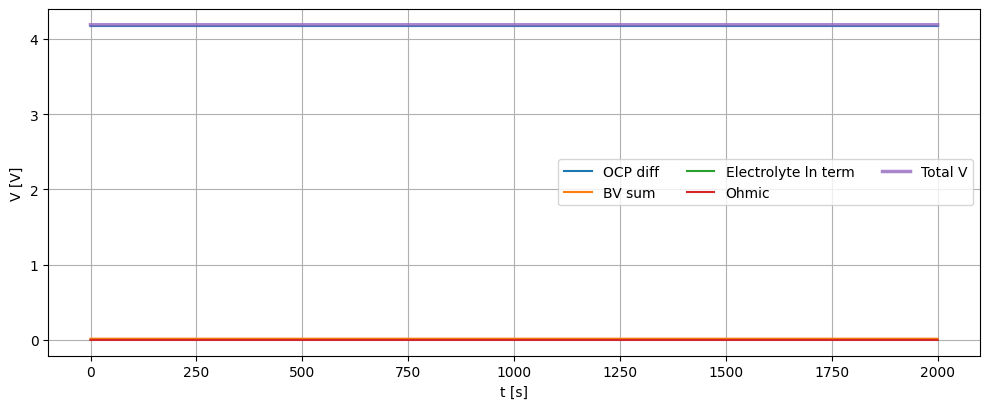

In [6]:
def plot_voltage_decomp(T, comp):
    plt.figure(figsize=(10,4.2))
    for k, lab in [("Udiff","OCP diff"), ("eta_sum","BV sum"),
                   ("dphi_e","Electrolyte ln term"), ("ohmic","Ohmic")]:
        plt.plot(T, comp[k], label=lab)
    plt.plot(T, comp["V"], lw=2.5, label="Total V", alpha=0.8)
    plt.grid(True); plt.xlabel("t [s]"); plt.ylabel("V [V]")
    plt.legend(ncol=3); plt.tight_layout(); plt.show()

# usage (after you already computed C_eq40):
plot_voltage_decomp(T_out, C_eq40)


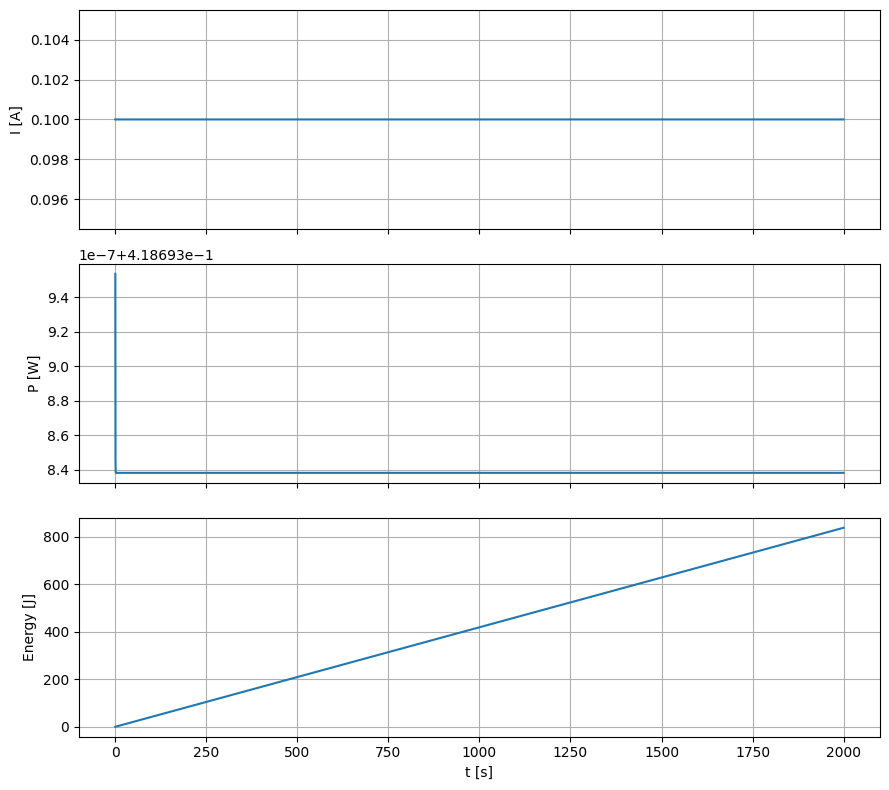

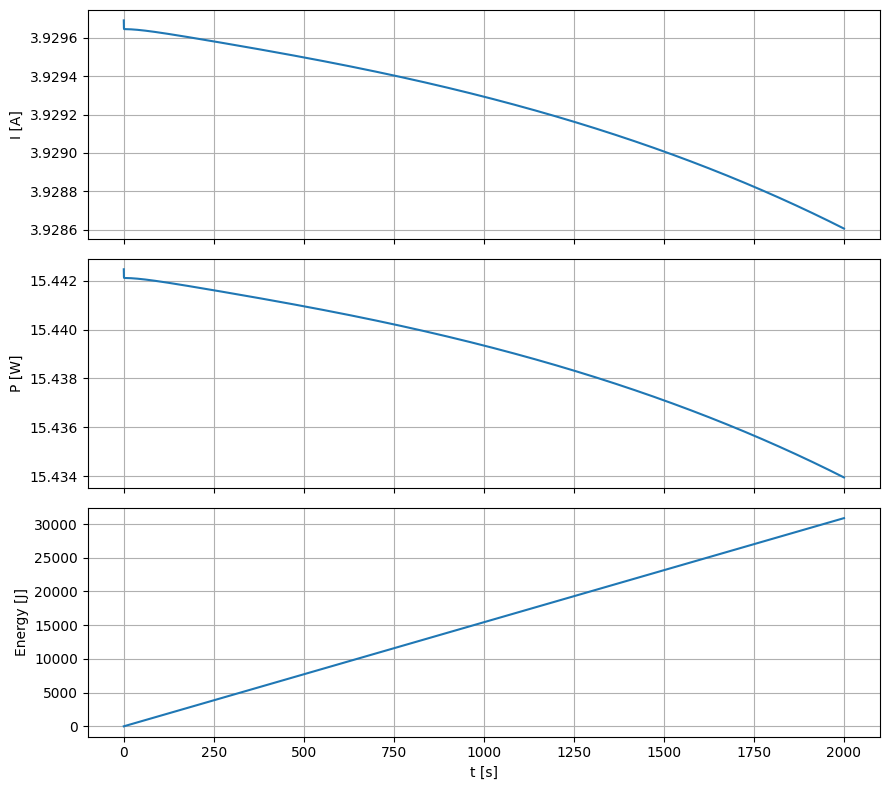

In [7]:
def plot_I_P_E(T, V, I):
    P = V*I
    dt = np.diff(T, prepend=T[0])
    E = np.cumsum(P * dt)             # Joules (Ws)
    fig, axs = plt.subplots(3,1,figsize=(9,8), sharex=True)
    axs[0].plot(T, I); axs[0].set_ylabel("I [A]"); axs[0].grid(True)
    axs[1].plot(T, P); axs[1].set_ylabel("P [W]"); axs[1].grid(True)
    axs[2].plot(T, E); axs[2].set_ylabel("Energy [J]"); axs[2].grid(True)
    axs[2].set_xlabel("t [s]")
    plt.tight_layout(); plt.show()

# example: linear run (forced_response)
plot_I_P_E(T_out, V_eq40, U)

# example: nonlinear feedback run (battery_nl)
I_fb = Vg / nl_params["R_load"]
plot_I_P_E(t, Vg, I_fb)


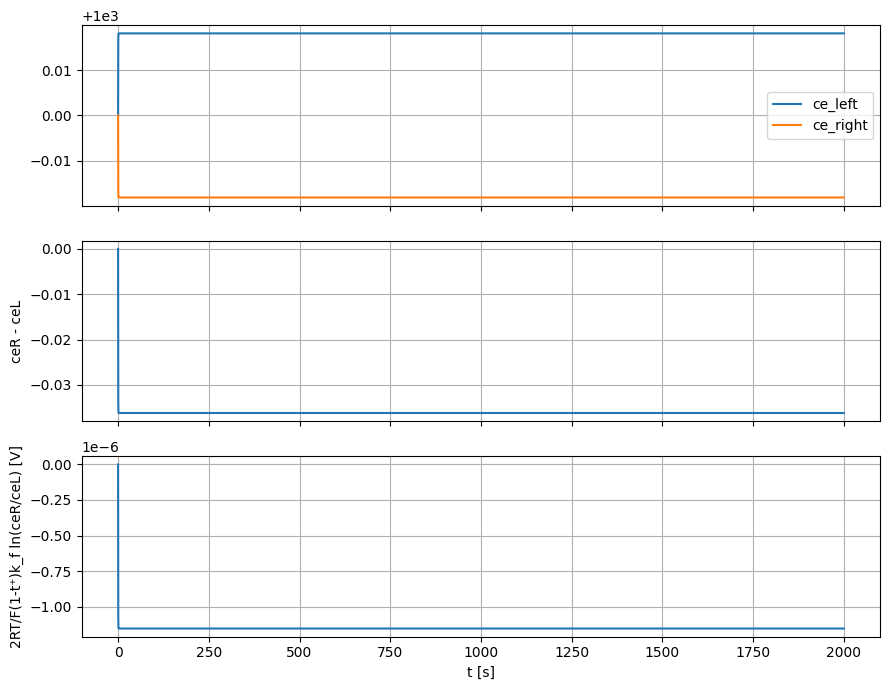

In [8]:
def plot_electrolyte_ends(T, ceL, ceR, vpar):
    ln_arg = np.clip(ceR/np.clip(ceL,1e-12,None), 1e-12, None)
    dphi_e = (2*R_GAS*vpar.T/PP.F)*(1-vpar.t_plus)*vpar.k_f*np.log(ln_arg)
    fig, axs = plt.subplots(3,1,figsize=(9,7), sharex=True)
    axs[0].plot(T, ceL, label="ce_left"); axs[0].plot(T, ceR, label="ce_right"); axs[0].legend(); axs[0].grid(True)
    axs[1].plot(T, ceR - ceL); axs[1].set_ylabel("ceR - ceL"); axs[1].grid(True)
    axs[2].plot(T, dphi_e); axs[2].set_ylabel("2RT/F(1-t⁺)k_f ln(ceR/ceL) [V]"); axs[2].grid(True)
    axs[2].set_xlabel("t [s]"); plt.tight_layout(); plt.show()

# usage (you already have C_eq40 with ceL/ceR):
plot_electrolyte_ends(T_out, C_eq40["ceL"], C_eq40["ceR"], vpar)


In [9]:
def plot_surface_stoich(T, X_TN, vpar):
    xp = np.clip(X_TN[:, IDX["cp_surf"]]/vpar.cs_p_max, 1e-9, 1-1e-9)
    xn = np.clip(X_TN[:, IDX["cn_surf"]]/vpar.cs_n_max, 1e-9, 1-1e-9)
    plt.figure(figsize=(9,4))
    plt.plot(T, xn, label="x_n (surf)"); plt.plot(T, xp, label="x_p (surf)")
    plt.grid(True); plt.xlabel("t [s]"); plt.ylabel("Stoichiometry [-]")
    plt.legend(); plt.tight_layout(); plt.show()


In [10]:
def eigs_along_traj(sys_nl, T, X):
    vals = []
    for k in range(0, len(T), max(1, len(T)//100)):   # sample up to 100 points
        try:
            G = ct.linearize(sys_nl, X[:,k], 0)       # returns StateSpace
            vals.append(np.max(np.real(np.linalg.eigvals(G.A))))
        except Exception:
            vals.append(np.nan)
    ts = T[::max(1, len(T)//100)]
    plt.figure(figsize=(9,3.6))
    plt.plot(ts, vals, marker='.')
    plt.axhline(0, color='k', lw=1)
    plt.grid(True); plt.xlabel("t [s]")
    plt.ylabel("max Re(λ(A_lin))")
    plt.title("Largest real-part eigenvalue along trajectory")
    plt.tight_layout(); plt.show()

# usage: eigs_along_traj(battery_nl, t, X)


c:\Users\onyer\OneDrive\Desktop\Research work\1. Projects\Battery_Analysis1\envenv\Lib\site-packages\control\phaseplot.py:845: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(xlim)
c:\Users\onyer\OneDrive\Desktop\Research work\1. Projects\Battery_Analysis1\envenv\Lib\site-packages\control\phaseplot.py:846: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(ylim)
c:\Users\onyer\OneDrive\Desktop\Research work\1. Projects\Battery_Analysis1\envenv\Lib\site-packages\control\nlsys.py:1553: RuntimeWarning: invalid value encountered in scalar divide
  dt = (t - T[idx-1]) / (T[idx] - T[idx-1])


ValueError: State vector is the wrong shape

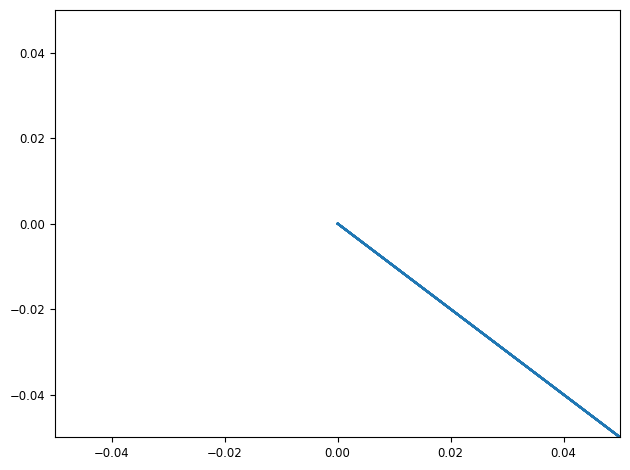

In [11]:
def make_2d_slice_system(i, j, A, B, vpar, R_load, x_fixed):
    def upd(t, z, u, params):
        x = x_fixed.copy()
        x[i], x[j] = z[0], z[1]
        Vg = voltage_state_only(x, vpar)
        I  = Vg / R_load
        dx = A @ x + B[:,0]*I
        return np.array([dx[i], dx[j]])
    return ct.nlsys(upd, states=2, inputs=0, name=f"slice_{i}_{j}")

# Example: phase plane for (ce_left, ce_right) = (8, 13)
x_fix = make_x0(0.2, 0.9, 0.0)
sys2d = make_2d_slice_system(8, 13, A, B, vpar, R_load=1.0, x_fixed=x_fix)
ct.phase_plane_plot(sys2d, [x_fix[8]*0.5, x_fix[8]*1.5, x_fix[13]*0.5, x_fix[13]*1.5])
plt.xlabel("ce_left"); plt.ylabel("ce_right"); plt.tight_layout(); plt.show()


In [12]:
# Example: compare two R_load values
resp1 = ct.input_output_response(battery_nl, t, 0, X0=x0)
nl_params_R2 = {**nl_params, "R_load": 2.0}
battery_nl_R2 = ct.nlsys(battery_update, battery_output, params=nl_params_R2,
                         states=state_names, outputs=state_names+["Vg"], inputs=0)
resp2 = ct.input_output_response(battery_nl_R2, t, 0, X0=x0)

ct.combine_time_responses([resp1, resp2],
    trace_labels=[f"R={nl_params['R_load']}Ω", "R=2Ω"]).plot()
plt.tight_layout(); plt.show()


ValueError: input plotting requested but no inputs in time response data